In [31]:
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
import random
import math
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix 
import numpy as np

random_state = 73

In [32]:
# read in the data and look at the head of the dataframe 
df = pd.read_csv("../data/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [33]:
is_categorical = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope"]
is_continuous = ["Age","RestingBP","Cholesterol","MaxHR", "Oldpeak"]

cat_ftrs = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope"]
ordinal_ftrs =[]
ordinal_cats = []
num_ftrs = ["Age","RestingBP","Cholesterol","MaxHR", "Oldpeak"]

In [34]:
len(df[df["Cholesterol"] ==0])
# here we see 172 people have cholesterol encoded as 0 which must be a missing value.

172

In [35]:
len(df[df["RestingBP"] == 0])
#and one patient does not have blood pressure. missing data point.

1

In [36]:
y = df['HeartDisease'] # assign our attributes and target variable
X = df.loc[:, df.columns != 'HeartDisease']

In [37]:
#this creates dataframe splits (startingi from scratch due to df drop)
df = pd.read_csv("../data/heart.csv") #read in

df['Cholesterol'] = df['Cholesterol'].replace(0,np.nan) # replace junk values with nan
df['RestingBP'] = df['RestingBP'].replace(0,np.nan)

y = df['HeartDisease']
df.drop(columns=['HeartDisease'],inplace=True)
X = df.values
ftrs = df.columns

In [38]:
random_state = 73
X_train, X_other, y_train, y_other = train_test_split(df, y, train_size=0.7, random_state=random_state)
X_test, X_CV, y_test, y_CV = train_test_split(X_other, y_other, test_size=.5, random_state=random_state)
print(len(X_CV))
print(len(X_train))
print(len(X_test))

138
642
138


In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [40]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# collect feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['cat'][1].get_feature_names(cat_ftrs)) + \
                preprocessor.transformers_[2][-1]

df_train = pd.DataFrame(data=X_prep,columns=feature_names)




# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)


# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)


In [41]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=10),max_iter=100, random_state=1000)
X_impute = imputer.fit_transform(df_train)
df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)


df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

/opt/anaconda3/envs/Data1030/lib/python3.9/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [42]:
np.nan in df_train_imp

False

In [43]:
### XGB using non-imputed

import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
              "max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()



clf = GridSearchCV(XGB, parameters, n_jobs=5, 
                   cv, shuffle=True, 
                   scoring='recall',
                   verbose=False, )

clf.fit(df_train, df_CV)



XGB.set_params(Param)
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))


NameError: name 'Param' is not defined

the CV RMSE: 0.33110283101362953
the test RMSE: 0.3963617729764686
the test R2: 0.366801489251358


In [45]:

df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
Age,1.000000,0.263084,0.058758,0.198039,-0.382045,0.258612
RestingBP,0.263084,1.000000,0.095939,0.067823,-0.109693,0.174252
Cholesterol,0.058758,0.095939,1.000000,0.054012,-0.019856,0.058488
FastingBS,0.198039,0.067823,0.054012,1.000000,-0.131438,0.052698
MaxHR,-0.382045,-0.109693,-0.019856,-0.131438,1.000000,-0.160691
Oldpeak,0.258612,0.174252,0.058488,0.052698,-0.160691,1.000000



contains NaN:
df_train
df_CV
df_test

does not contain NaN:
df_train_imp   // y_train
df_test_imp    // y_test
df_CV_imp      // y_CV



# KNN Model

In [114]:
from sklearn.neighbors import KNeighborsClassifier
KNN_val_scores= []
KNN_train_scores =[]
best_score =0 
best_n = 0
for i in range(1,40):
    KNN = KNeighborsClassifier(n_neighbors = i)
    KNN.fit(df_train_imp,y_train)
    pred_i = KNN.predict(df_CV_imp)
    val_score = recall_score(y_CV,pred_i)
    
    pred_i = KNN.predict(df_train_imp)
    train_score = recall_score(y_train, pred_i)
    if val_score > best_score:
        best_n = i
        best_score = val_score
    KNN_val_scores.append(val_score)
    KNN_train_scores.append(train_score)
    

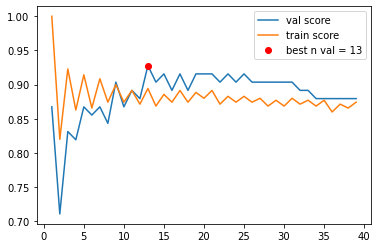

In [115]:
plt.plot(range(1,40),KNN_val_scores, label = "val score")
plt.plot(range(1,40),KNN_train_scores, label = "train score")
plt.plot(best_n, best_score, "o", color = "red",label = f"best n val = {best_n}")
plt.legend()
plt.show()

In [116]:
best_score

0.927710843373494

In [48]:
# now we can run the model on the test set and evaluate the results 

KNN = KNeighborsClassifier(n_neighbors = 13)
KNN.fit(df_train_imp,y_train)
y_pred = KNN.predict(df_test_imp)

# get multiple measure for evaluating the model's results  
print('Accuracy Score : {}'.format(accuracy_score(y_test,y_pred)))
print('Precision Score : {}'.format(precision_score(y_test,y_pred)))
print('Recall Score : {}'.format(recall_score(y_test,y_pred)))
print('F1 Score : {}'.format(f1_score(y_test,y_pred)))
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
print('True Positives : {}'.format(tp))
print('True Negative : {}'.format(tn))
print('False Positives : {}'.format(fp))
print('False Negatives : {}'.format(fn))

Accuracy Score : 0.855072463768116
Precision Score : 0.8395061728395061
Recall Score : 0.9066666666666666
F1 Score : 0.8717948717948718
True Positives : 68
True Negative : 50
False Positives : 13
False Negatives : 7


# Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier()
n_values = range(1,150)
grid = dict(n_estimators=n_values)

In [60]:
#this takes too long to run.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}


In [61]:
model=RandomForestClassifier()
grid_search=GridSearchCV(estimator=model,param_grid=grid,cv=3)
grid_result = grid_search.fit(df_train_imp,y_train)

KeyboardInterrupt: 

In [ ]:
print("tuned hpyerparameters :",grid_result.best_params_)
print("accuracy :",grid_result.best_score_)

In [ ]:
# now we can run the model on the test set and evaluate the results 
clf = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'])
clf.fit(df_train_imp,y_train)
y_pred = clf.predict(df_test_imp)

# get multiple measure for evaluating the model's results  

print('Accuracy Score : {}'.format(accuracy_score(y_test,y_pred)))
print('Precision Score : {}'.format(precision_score(y_test,y_pred)))
print('Recall Score : {}'.format(recall_score(y_test,y_pred)))
print('F1 Score : {}'.format(f1_score(y_test,y_pred)))
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
print('True Positives : {}'.format(tp))
print('True Negative : {}'.format(tn))
print('False Positives : {}'.format(fp))
print('False Negatives : {}'.format(fn))

In [117]:
from sklearn.ensemble import RandomForestClassifier

val_scores = []
train_scores =[]
best_score = 0
best_n = 0
for n in range(1,150):
    forest= RandomForestClassifier(n_estimators =n, random_state = 0)
    forest.fit(df_train_imp, y_train)
    val_prediction = forest.predict(df_CV_imp)
    train_prediction = forest.predict(df_train_imp)
    val_score = recall_score(y_CV,val_prediction)
    train_score = recall_score(y_train,train_prediction)
    train_scores.append(train_score)
    val_scores.append(val_score)
    if val_score > best_score:
        best_score = val_score
        best_n = n
                                

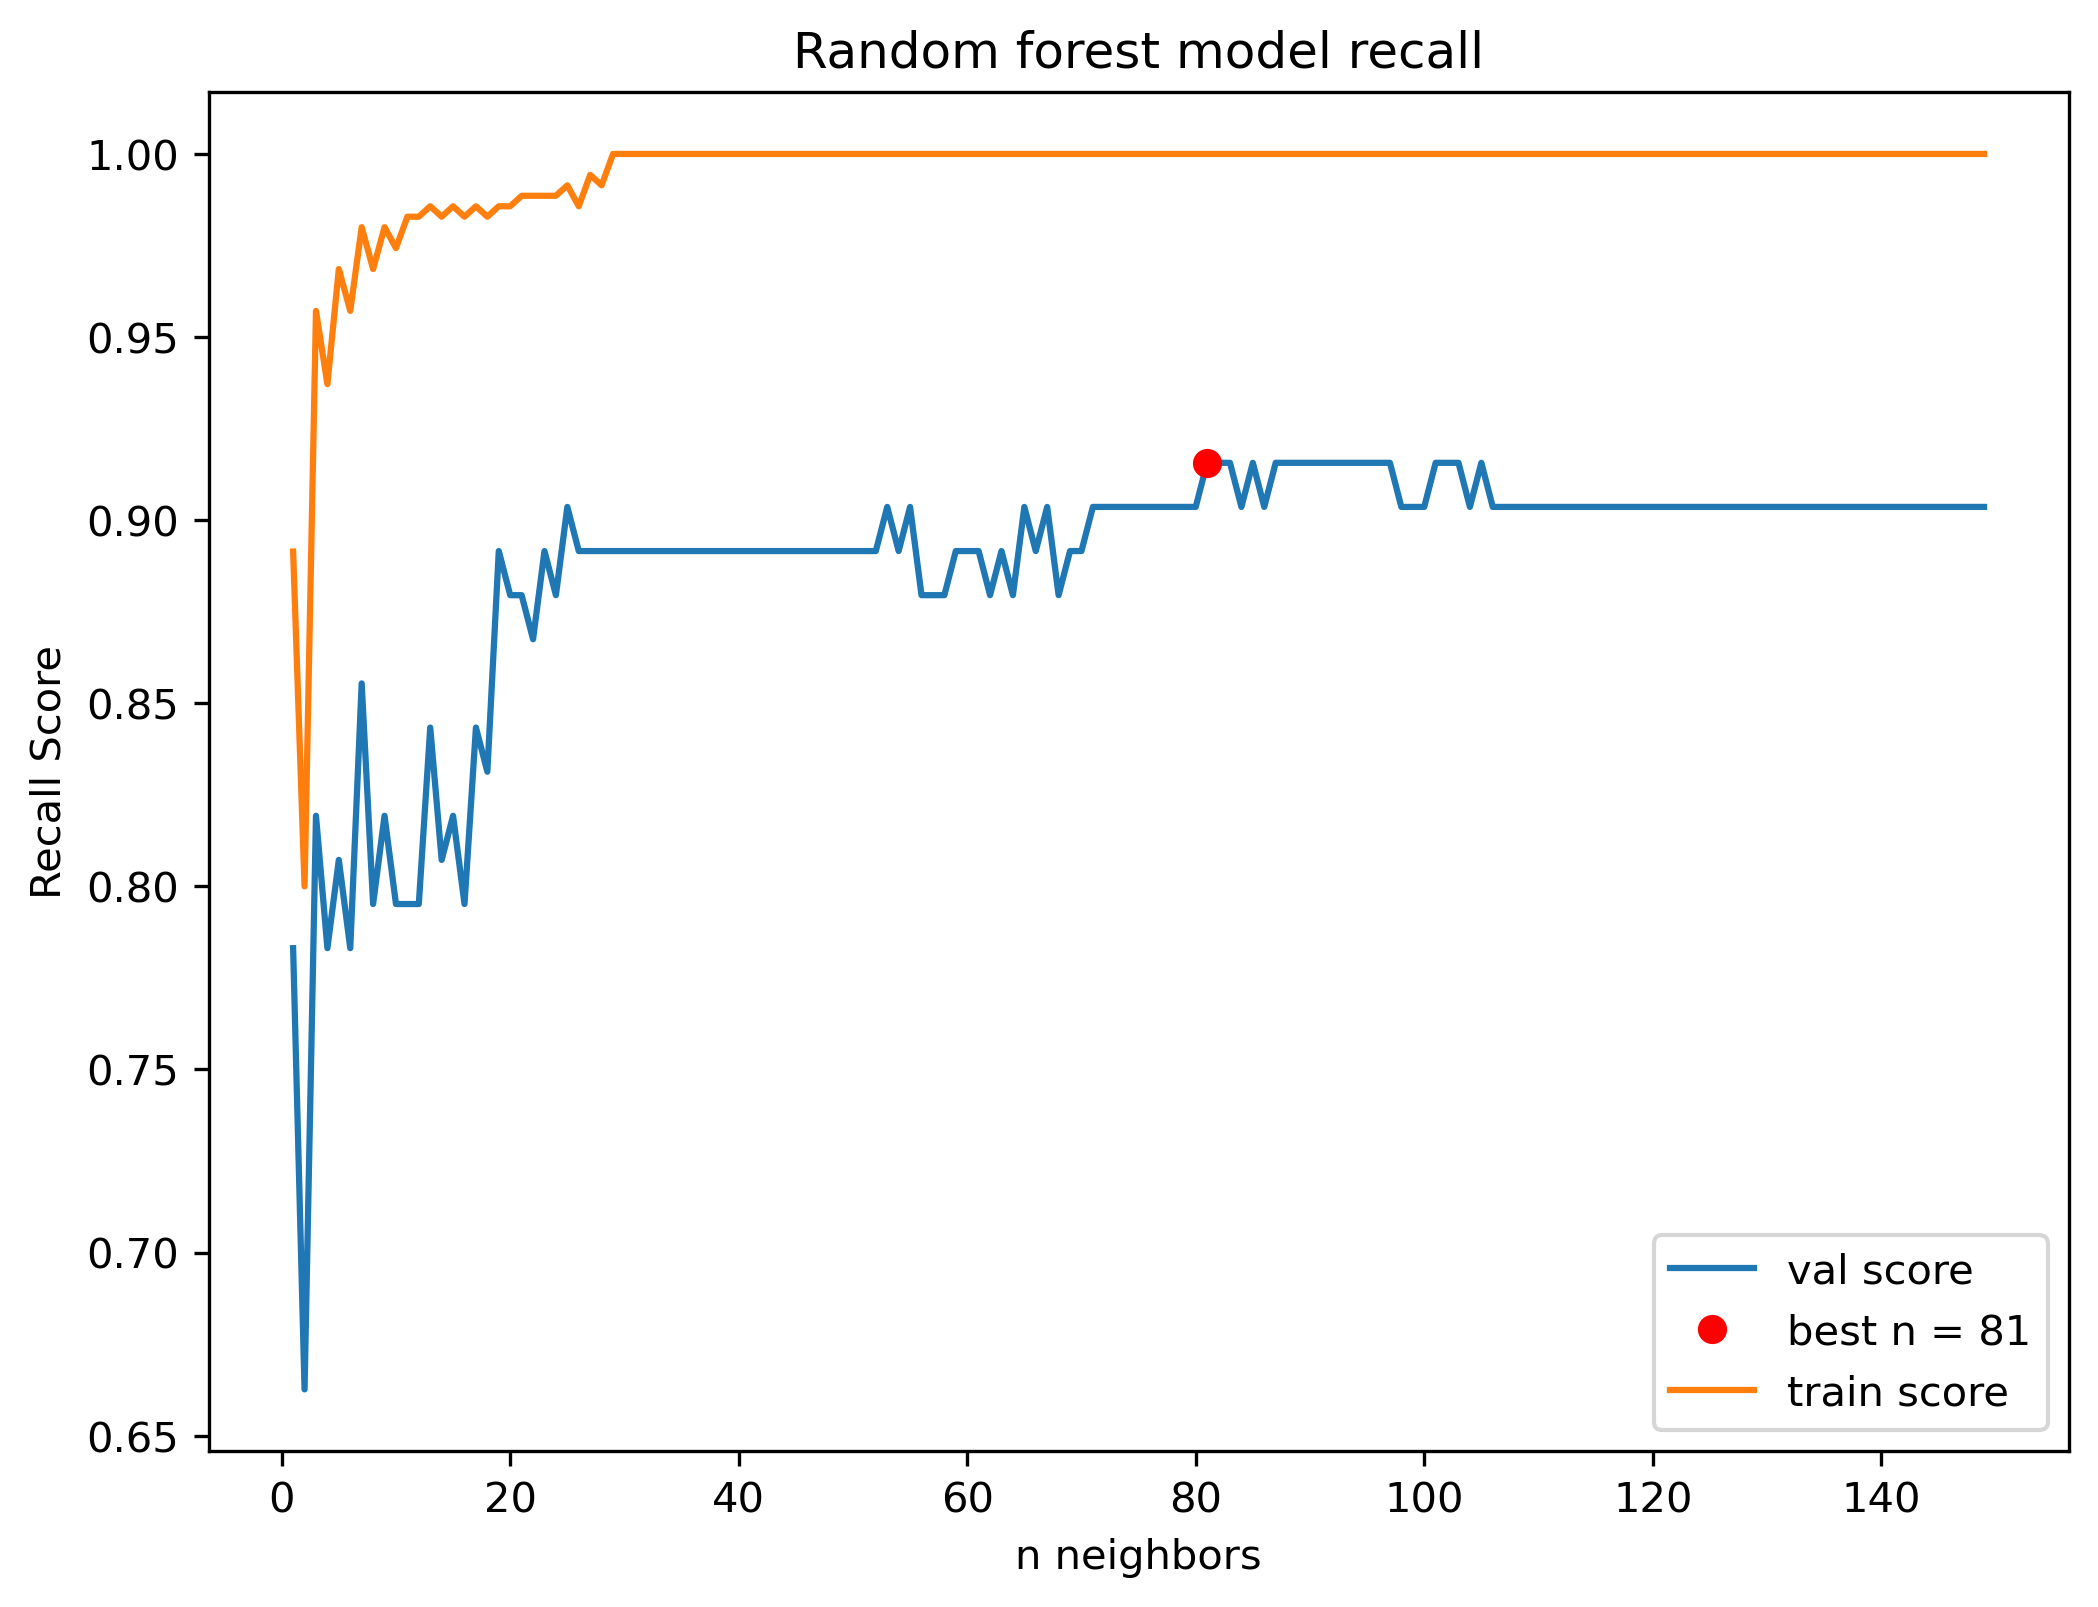

In [118]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(range(1,150), val_scores, label= "val score")
plt.plot(best_n, best_score, "o", color = "red", label = f"best n = {best_n}")
plt.plot(range(1,150),train_scores, label = "train score")
plt.legend()
plt.title("Random forest model recall")
plt.xlabel("n neighbors")
plt.ylabel("Recall Score")
plt.savefig(f"../figures/random_forest_recall.png",bbox_inches="tight", dpi = 300)
plt.show()

In [119]:
forest= RandomForestClassifier(n_estimators =best_n, random_state = 0)
forest.fit(df_train_imp, y_train)
prediction = forest.predict(df_test_imp)
score = np.mean(prediction != y_test)
print(best_score)

0.9156626506024096


In [57]:
# now we can run the model on the test set and evaluate the results 
clf = RandomForestClassifier(n_estimators=best_n, random_state=38)
clf.fit(df_train_imp,y_train)
y_pred = clf.predict(df_test_imp)

# get multiple measure for evaluating the model's results  
print('Accuracy Score : {}'.format(accuracy_score(y_test,y_pred)))
print('Precision Score : {}'.format(precision_score(y_test,y_pred)))
print('Recall Score : {}'.format(recall_score(y_test,y_pred)))
print('F1 Score : {}'.format(f1_score(y_test,y_pred)))
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
print('True Positives : {}'.format(tp))
print('True Negative : {}'.format(tn))
print('False Positives : {}'.format(fp))
print('False Negatives : {}'.format(fn))

Accuracy Score : 0.8405797101449275
Precision Score : 0.8441558441558441
Recall Score : 0.8666666666666667
F1 Score : 0.8552631578947368
True Positives : 65
True Negative : 51
False Positives : 12
False Negatives : 10


# Support Vector Machine 

In [82]:
from sklearn.svm import SVC
from sklearn.svm import SVR
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
c_values = np.logspace(-3,3,3)
degree_values = [3,8]
coef0_values = [0.01,10,0.5]
gamma_values = ['auto','scale']
grid = dict(C=c_values,
            kernel=kernel_values,
            degree=degree_values,
            gamma=gamma_values,
            coef0=coef0_values)


In [83]:
model=SVC()
grid_search=GridSearchCV(estimator=model,param_grid=grid,cv=3)
grid_result = grid_search.fit(df_train_imp,y_train)

In [84]:
print("tuned hpyerparameters :",grid_result.best_params_)
print("accuracy :",grid_result.best_score_)

tuned hpyerparameters : {'C': 1.0, 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
accuracy : 0.8598130841121495


In [85]:
# now we can run the model on the test set and evalutae the results 
clf = SVC(C = grid_result.best_params_['C'],
          coef0 = grid_result.best_params_['coef0'],
          degree = grid_result.best_params_['degree'],
          gamma = grid_result.best_params_['gamma'],
          kernel = grid_result.best_params_['kernel'])
clf.fit(df_train_imp,y_train)
y_pred = clf.predict(df_test_imp)

# get multiple measure for evaluating the model's results  
print('Accuracy Score : {}'.format(accuracy_score(y_test,y_pred)))
print('Precision Score : {}'.format(precision_score(y_test,y_pred)))
print('Recall Score : {}'.format(recall_score(y_test,y_pred)))
print('F1 Score : {}'.format(f1_score(y_test,y_pred)))
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
print('True Positives : {}'.format(tp))
print('True Negative : {}'.format(tn))
print('False Positives : {}'.format(fp))
print('False Negatives : {}'.format(fn))

Accuracy Score : 0.8695652173913043
Precision Score : 0.8518518518518519
Recall Score : 0.92
F1 Score : 0.8846153846153846
True Positives : 69
True Negative : 51
False Positives : 12
False Negatives : 6


# Logistic Regression

In [86]:



# Use gridsearch to evaluate hyperparameters for logistic regression 
# some of these solver/penalty combos will not work so expecting a lot of error warnings below 
c_values = np.logspace(-3,3,3)
penalty_values = ["l1", "l2", "elasticnet"]
solvers_values = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
grid = dict(solver=solvers_values, penalty=penalty_values, C=c_values)


model = LogisticRegression()
grid_search = GridSearchCV(estimator=model,param_grid=grid,cv=3,scoring= 'recall')
grid_result = grid_search.fit(df_train_imp,y_train)


/opt/anaconda3/envs/Data1030/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Data1030/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/Data1030/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/Data1030/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anac

In [87]:
print("tuned hpyerparameters :", grid_result.best_params_)
print("accuracy :", grid_result.best_score_)

tuned hpyerparameters : {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
accuracy : 1.0


In [88]:
# now we can run the model on the test set and evalutae the results 
clf = LogisticRegression(C = grid_result.best_params_['C'],
                         penalty = grid_result.best_params_['penalty'],
                         solver = grid_result.best_params_['solver'])
clf.fit(df_train_imp,y_train)
y_pred = clf.predict(df_test_imp)

# get multiple measure for evaluating the model's results  
print('Accuracy Score : {}'.format(accuracy_score(y_test,y_pred)))
print('Precision Score : {}'.format(precision_score(y_test,y_pred)))
print('Recall Score : {}'.format(recall_score(y_test,y_pred)))
print('F1 Score : {}'.format(f1_score(y_test,y_pred)))
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
print('True Positives : {}'.format(tp))
print('True Negative : {}'.format(tn))
print('False Positives : {}'.format(fp))
print('False Negatives : {}'.format(fn))

Accuracy Score : 0.5434782608695652
Precision Score : 0.5434782608695652
Recall Score : 1.0
F1 Score : 0.704225352112676
True Positives : 75
True Negative : 0
False Positives : 63
False Negatives : 0


In [ ]:
#Base

# Base line scoring

In [71]:
import random
random.seed(12323)

In [98]:
seeds = [1345*x+297 for x in range(1,10000)]
recalls = []
precisions = []
F1s = []
accuracies = []

for seed in seeds:
    random.seed(seed)
    y_pred = [random.randint(0,1) for _ in range(0,len(df))]
    recalls.append(recall_score(y,y_pred))
    accuracies.append(accuracy_score(y,y_pred))
    F1s.append(f1_score(y,y_pred))
    precisions.append(precision_score(y,y_pred))
    



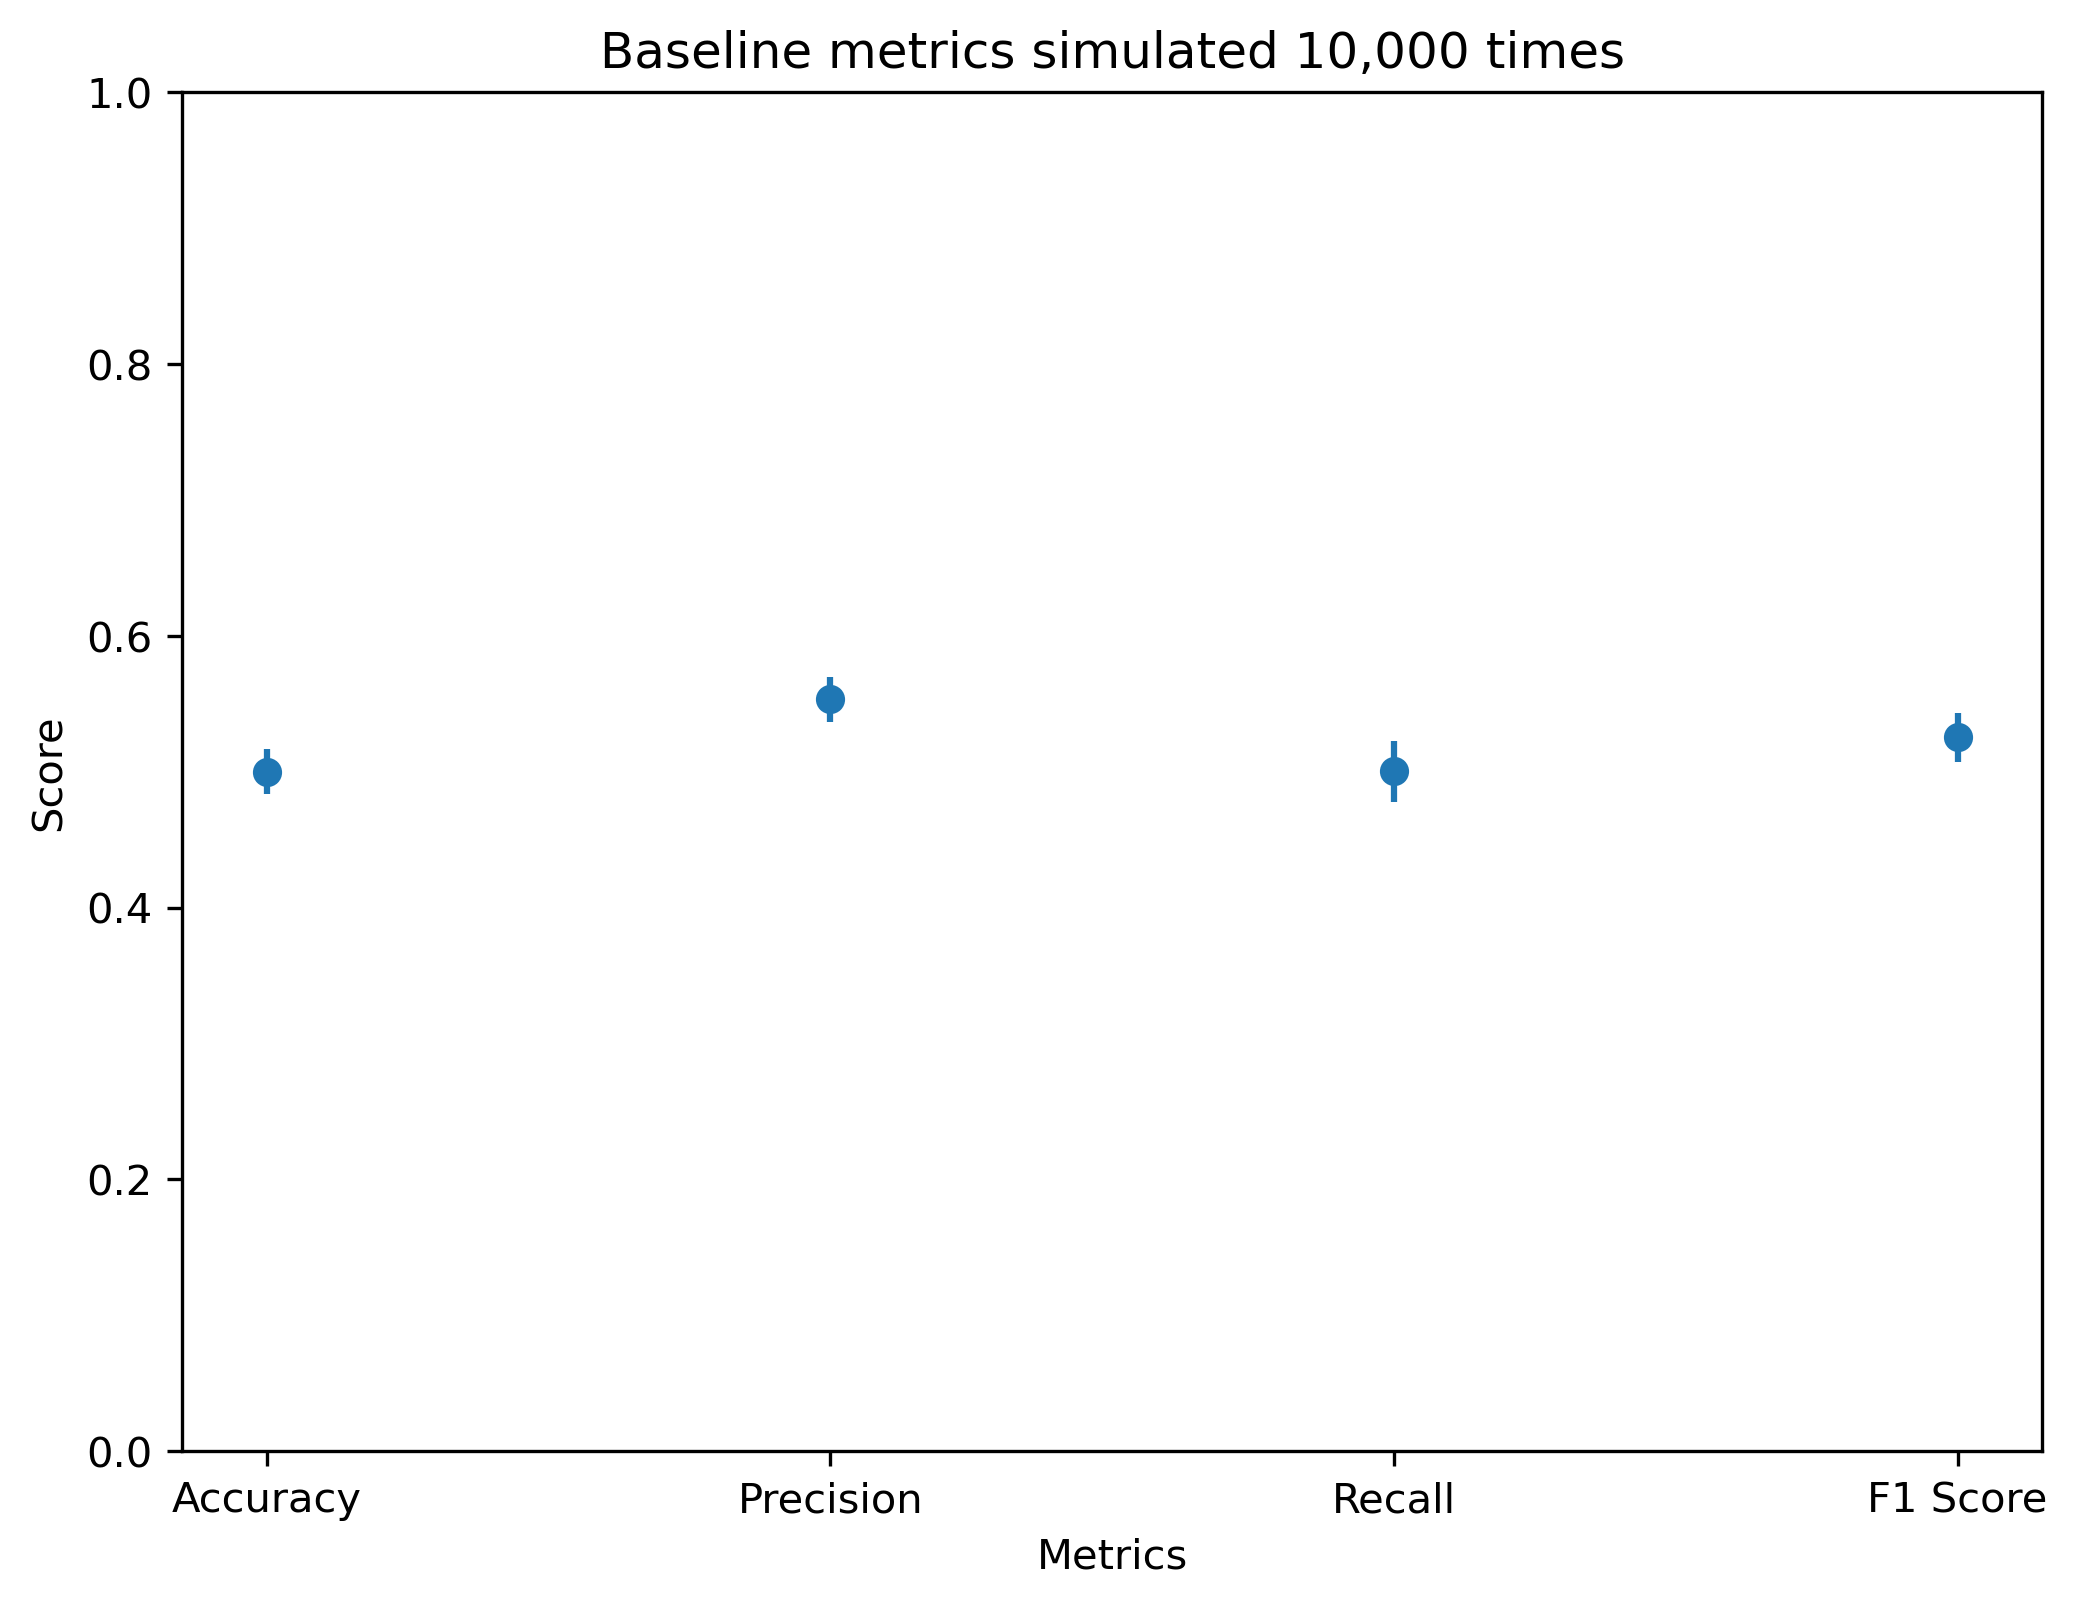

In [103]:
scores = ["Accuracy", "Precision", "Recall", "F1 Score"]
means = [np.mean(accuracies),np.mean(precisions), np.mean(recalls),np.mean(F1s)]
stds = [np.std(accuracies),np.std(precisions), np.std(recalls),np.std(F1s)]
plt.figure(figsize=(8,6), dpi=300)
plt.errorbar(scores,means, yerr = stds,fmt="o")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.title("Baseline metrics simulated 10,000 times")
plt.ylim(0,1)
plt.savefig(f"../figures/baseline_scores.png",bbox_inches="tight", dpi = 300)
plt.show()

<Figure size 2400x1800 with 0 Axes>

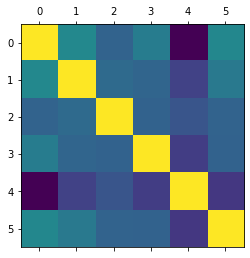

In [106]:
plt.figure(figsize=(8,6), dpi=300)
plt.matshow(df.corr())

plt.show()

In [130]:
print(scores)
means

['Accuracy', 'Precision', 'Recall', 'F1 Score']


[0.5000167772768562,
 0.5533755294673472,
 0.5001346591352049,
 0.5252699497965785]

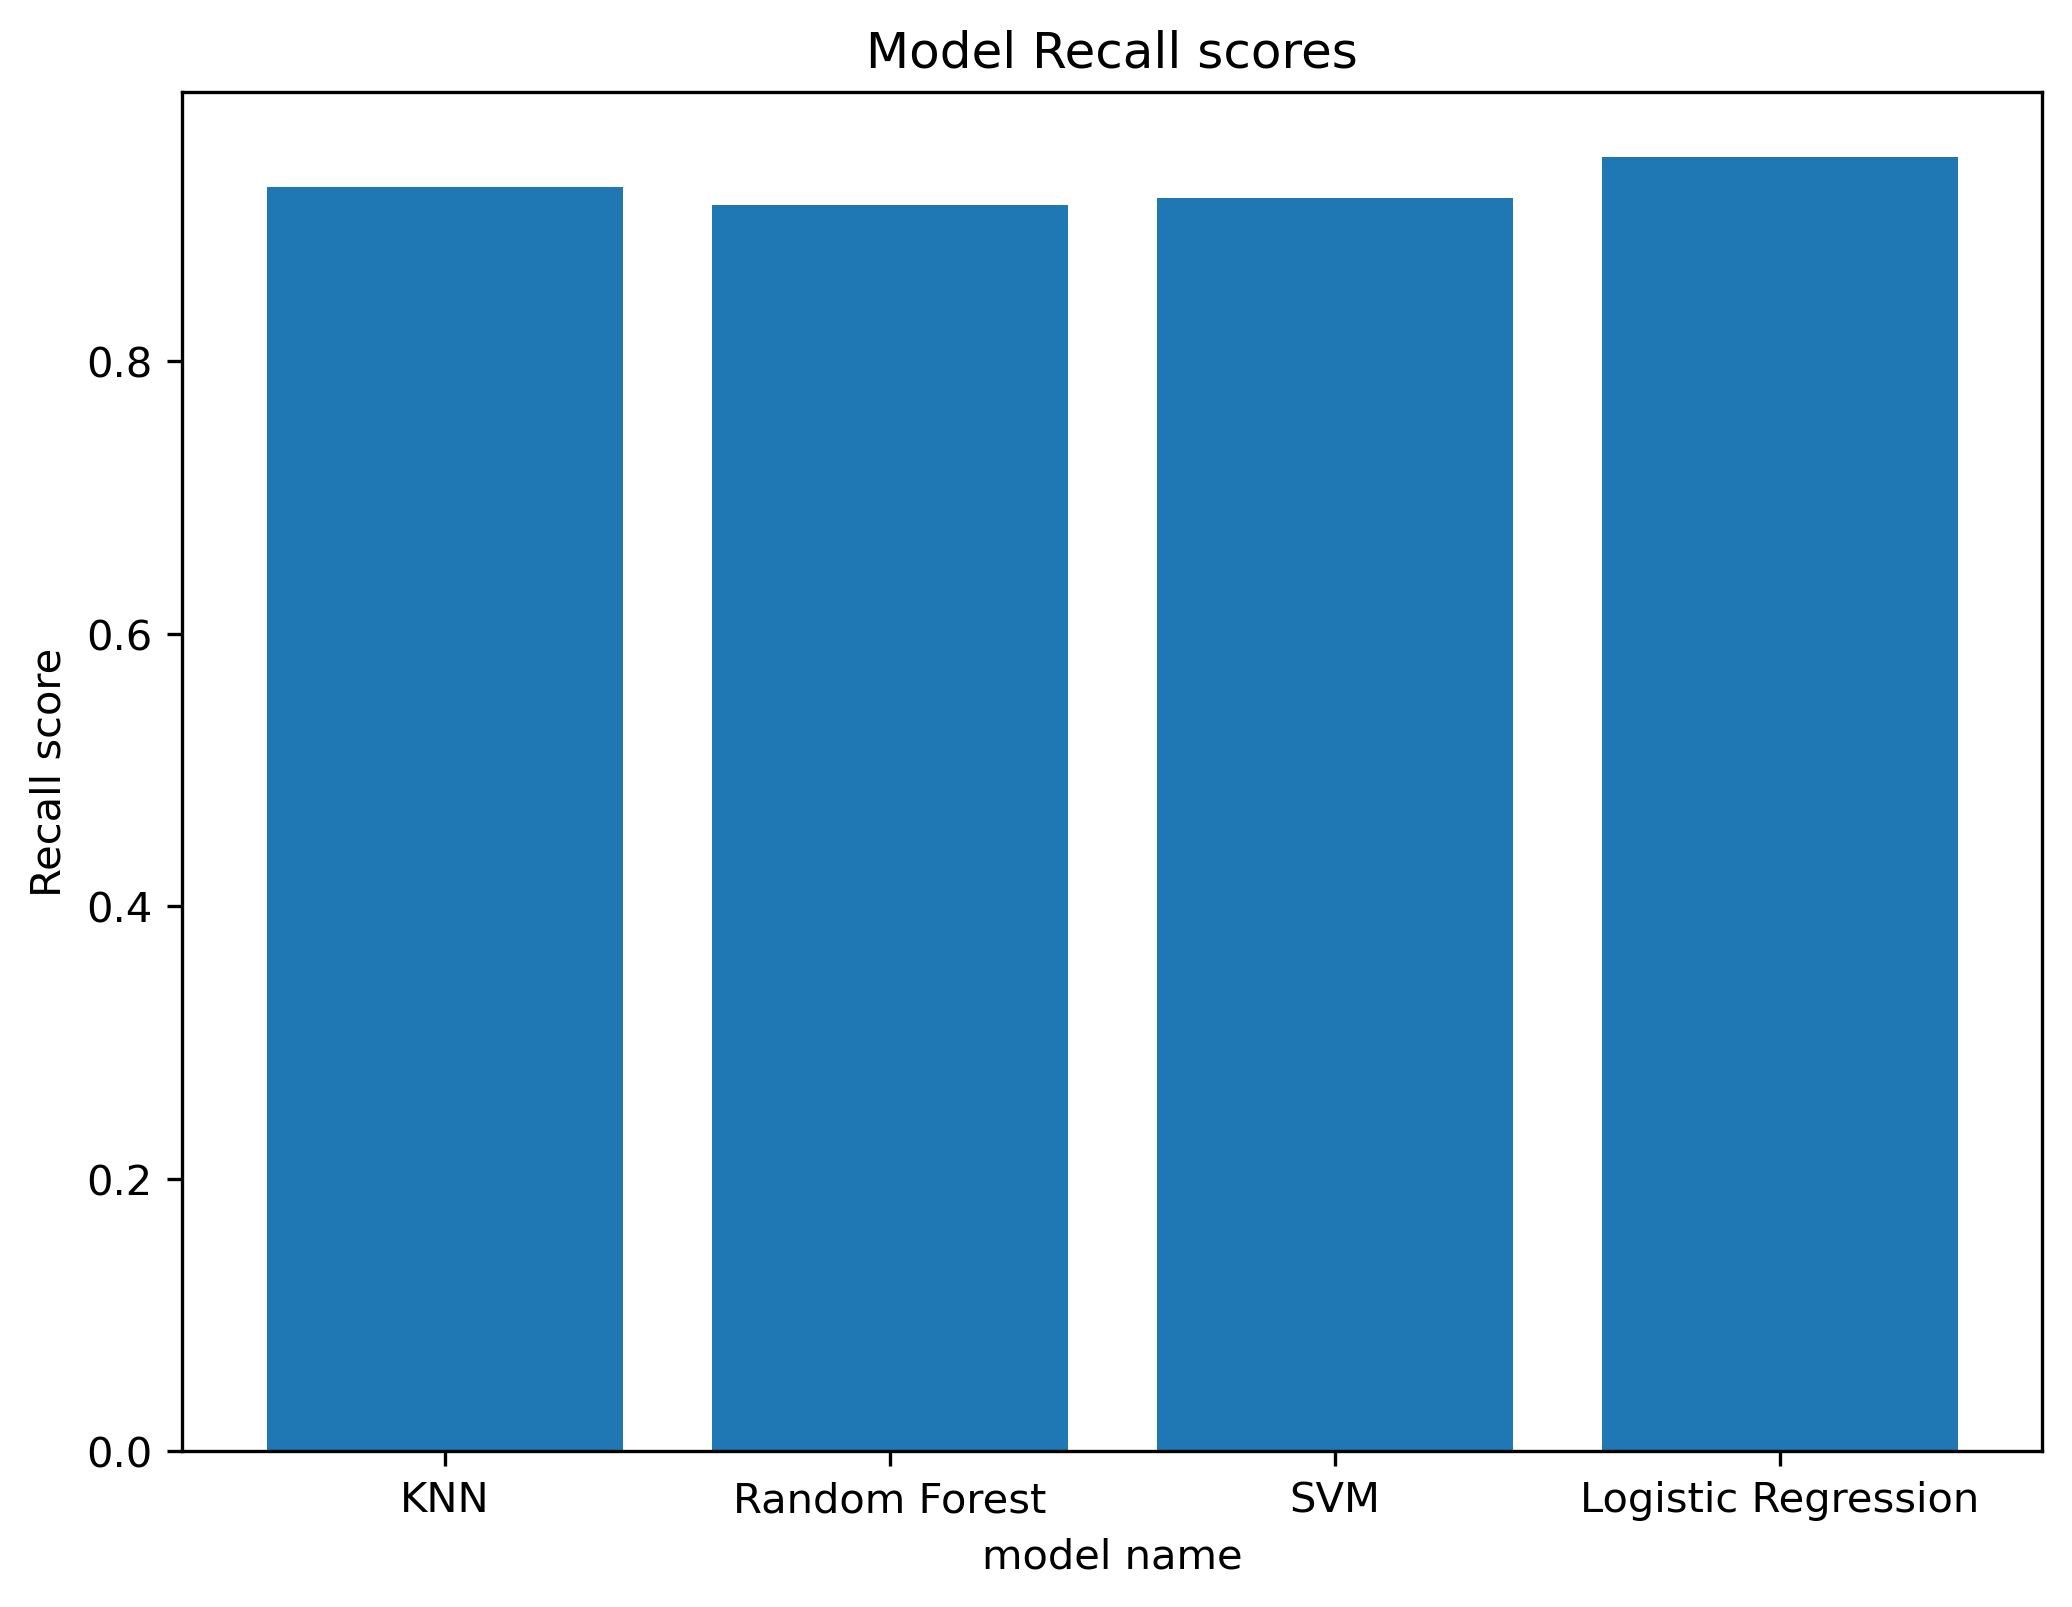

In [123]:
plt.figure(figsize=(8,6), dpi=300)

models = ["KNN", "Random Forest", "SVM", "Logistic Regression"]
recalls = [.9277, .915, .92,.95]
matplotlib.pyplot.bar(models, recalls)
plt.title("Model Recall scores")
plt.xlabel("model name")
plt.ylabel("Recall score")
plt.savefig(f"../figures/final_bar.png",bbox_inches="tight", dpi = 300)
plt.show()


In [124]:
import shap
shap.initjs() # required for visualizations later on